# Explorative Analyse

Zunächst wird der originale Train-Datensatz explorativ analysiert und gegebenenfalls mit dem Test-Datensatz verglichen.

In [47]:
! pip install wordcloud
! pip install mlxtend
! pip install nltk



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd 
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from PIL import Image
from sklearn.utils import resample
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve,auc
from keras import regularizers
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from itertools import cycle

lemma = WordNetLemmatizer()
stopword = set(STOPWORDS)
nltk.download('omw-1.4')
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


from nltk.corpus import brown
nltk.download("brown")
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading brown: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [60]:
train_data = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train.csv")
test_data = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\test.csv")
train_cleaned_data = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train_cleaned.csv")
test_cleaned_data = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\test_cleaned.csv")


In [61]:
train_cleaned_data.sample(5)

,id,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
13117,14597,0,@user @user @user @user only a single word is...,single word require waste everything actually,4,[],NaN
20535,23304,0,hope most of my deliveries come 2day!! #weddin...,hope delivery come wedding bouquet grin squint...,0,"['#wedding', '#lastbitstodo']",":bouquet:,:grinning_squinting_face:,:person_wi..."
3194,3399,0,@user so many sycophants.....,many,1,[],NaN
3989,4263,1,#carl #paladino says #michelle #obama should #...,carl paladino say michelle obama live gorilla ...,0,"['#carl', '#paladino', '#michelle', '#obama', ...",NaN
12352,13693,0,i love planning things #100happydays #day40 #p...,plan thing paytime sign,0,"['#100happydays', '#day40', '#payplanning', '#...",NaN


### Hate-Speech vs kein Hate-Speech

In [62]:
import matplotlib.pyplot as plt

# Klassenverteilung in den ursprünglichen Trainingsdaten
train_label_counts = train_data['label'].value_counts()
print("Class Distribution in Original Train Data:")
print(train_label_counts)

# Klassenverteilung in den bereinigten Trainingsdaten
train_cleaned_label_counts = train_cleaned_data['label'].value_counts()
print("\nClass Distribution in Cleaned Train Data:")
print(train_cleaned_label_counts)




Class Distribution in Original Train Data:
label
0    29720
1     2242
Name: count, dtype: int64

Class Distribution in Cleaned Train Data:
label
0    25839
1     1811
Name: count, dtype: int64


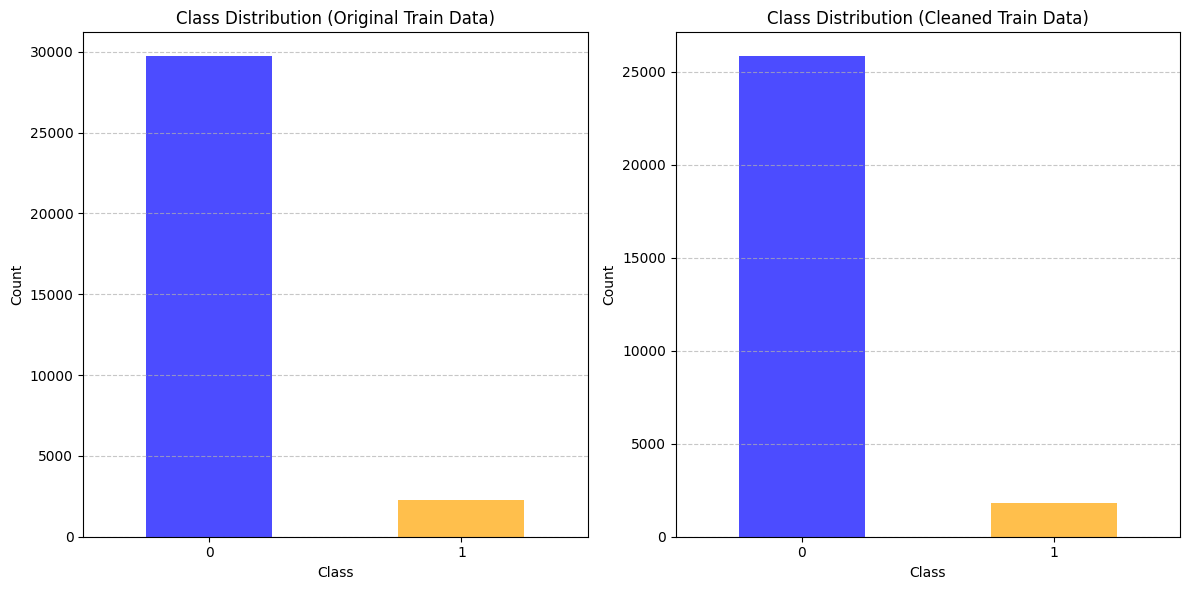

In [49]:
# Visualisierung der Klassenverteilung
plt.figure(figsize=(12, 6))

# Originale Daten
plt.subplot(1, 2, 1)
train_label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title('Class Distribution (Original Train Data)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bereinigte Daten
plt.subplot(1, 2, 2)
train_cleaned_label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title('Class Distribution (Cleaned Train Data)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Train Data Length Vs Test Data Length

In [66]:
# Berechnung der Länge der Tweets
train_data_len = train_data['tweet'].str.len()
test_data_len = test_data['tweet'].str.len()

train_cleaned_data_len = train_cleaned_data['tweet_cleaned'].str.len()
test_cleaned_data_len = test_cleaned_data['tweet_cleaned'].str.len()

# Statistiken für Trainingsdaten
print("Train Data Length Statistics:")
print(f"Mean Length: {train_data_len.mean():.2f}")
print(f"Median Length: {train_data_len.median():.2f}")
print(f"Minimum Length: {train_data_len.min()}")
print(f"Maximum Length: {train_data_len.max()}")
print(f"Standard Deviation: {train_data_len.std():.2f}\n")

# Statistiken für Testdaten
print("Test Data Length Statistics:")
print(f"Mean Length: {test_data_len.mean():.2f}")
print(f"Median Length: {test_data_len.median():.2f}")
print(f"Minimum Length: {test_data_len.min()}")
print(f"Maximum Length: {test_data_len.max()}")
print(f"Standard Deviation: {test_data_len.std():.2f} \n")

# Statistiken für bereinigten Trainingsdaten
print("Cleaned Train Data Length Statistics:")
print(f"Mean Length: {train_cleaned_data_len.mean():.2f}")
print(f"Median Length: {train_cleaned_data_len.median():.2f}")
print(f"Minimum Length: {train_cleaned_data_len.min()}")
print(f"Maximum Length: {train_cleaned_data_len.max()}")
print(f"Standard Deviation: {train_cleaned_data_len.std():.2f}\n")

# Statistiken für bereinigten Testdaten
print("Cleaned Train Data Length Statistics:")
print(f"Mean Length: {test_cleaned_data_len.mean():.2f}")
print(f"Median Length: {test_cleaned_data_len.median():.2f}")
print(f"Minimum Length: {test_cleaned_data_len.min()}")
print(f"Maximum Length: {test_cleaned_data_len.max()}")
print(f"Standard Deviation: {test_cleaned_data_len.std():.2f}\n")


Train Data Length Statistics:
Mean Length: 84.74
Median Length: 88.00
Minimum Length: 11
Maximum Length: 274
Standard Deviation: 29.46

Test Data Length Statistics:
Mean Length: 84.55
Median Length: 88.00
Minimum Length: 11
Maximum Length: 292
Standard Deviation: 29.61 

Cleaned Train Data Length Statistics:
Mean Length: 44.25
Median Length: 42.00
Minimum Length: 1.0
Maximum Length: 515.0
Standard Deviation: 23.77

Cleaned Train Data Length Statistics:
Mean Length: 42.47
Median Length: 40.00
Minimum Length: 1.0
Maximum Length: 532.0
Standard Deviation: 23.86



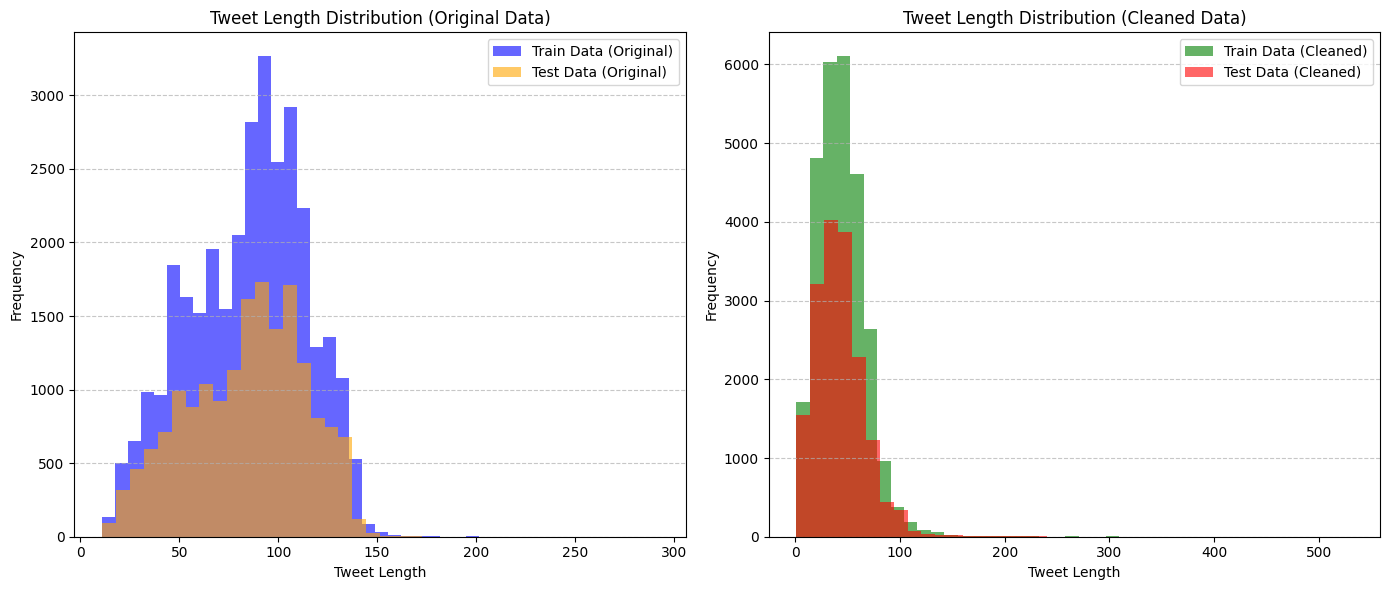

In [ ]:
# Erstellung der Subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Originaldaten
plt.subplot(1, 2, 1)
plt.hist(train_data_len, bins=40, alpha=0.6, label='Train Data (Original)', color='blue')
plt.hist(test_data_len, bins=40, alpha=0.6, label='Test Data (Original)', color='orange')
plt.title('Tweet Length Distribution (Original Data)')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Bereinigte Daten
plt.subplot(1, 2, 2)
plt.hist(train_cleaned_data_len, bins=40, alpha=0.6, label='Train Data (Cleaned)', color='green')
plt.hist(test_cleaned_data_len, bins=40, alpha=0.6, label='Test Data (Cleaned)', color='red')
plt.title('Tweet Length Distribution (Cleaned Data)')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Layout-Anpassung und Anzeige
plt.tight_layout()
plt.show()


Verteilung: Meiste Tweets zwischen 50-100 Zeichen.
Trainingsdaten vs. Testdaten: Trainingsdaten haben mehr längere Tweets.
Die Verteilung der Tweet-Längen zeigt eine Abnahme ab 100 Zeichen, was vermutlich mit der früheren Zeichenbegrenzung von Twitter zusammenhängt. Bis 2019 waren Tweets auf 140 Zeichen begrenzt. Da der Datensatz vermutlich vor 2019 erhoben wurde, spiegelt sich diese Begrenzung in der Verteilung wider.

### All Tweet Text Data WordCloud

In [ ]:
wordcloud_mask=np.array(Image.open("twitter.png"))
train_cleaned_data["tweet_cleaned"] = train_cleaned_data["tweet_cleaned"].astype(str)
all_tweet_text = " ".join(train_cleaned_data["tweet_cleaned"].tolist())
plt.figure(figsize=(6,6))
wordcloud=WordCloud(stopwords=stopword,width=800,height=480,max_words=100,mask=wordcloud_mask,colormap='RdYlGn').generate(all_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

TypeError: sequence item 36: expected str instance, float found

Häufige Wörter: "user," "day," "love," "life," "happy" – viele positive oder neutrale Themen.
Sonderzeichen: "ð," "â," "amp" – möglicherweise Kodierungsfehler, die bereinigt werden sollten.
Gefühle: Überwiegend positive Begriffe, was auf viele nicht-hassbezogene Tweets hindeutet.
Stoppwörter: Einige Stoppwörter wie "today" und "now" sind noch vorhanden.
Hassrede: Keine auffälligen Hassrede-Begriffe, mehr Fokus auf Alltagssprache aber wahrscheinlich wegen der Ungleichgewicht der Daten beider Klassen

### Positive (Hate-Speech) Tweet Text Data WordCloud

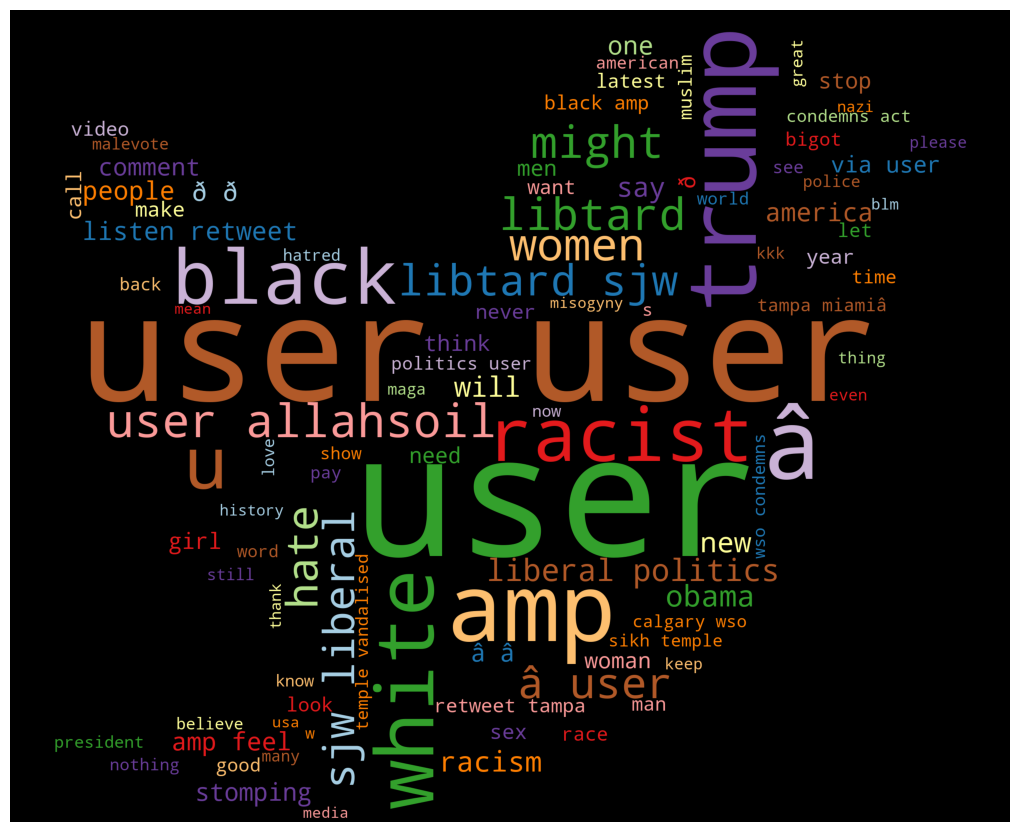

In [ ]:
racist_sexist_data=train_data[train_data.label==1]
racist_tweet_text=" ".join(racist_sexist_data["tweet"].tolist())
plt.figure(figsize=(6,6))
wordcloud=WordCloud(stopwords=stopword,width=1600,height=800,max_words=100,mask=wordcloud_mask,colormap='Paired').generate(racist_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

Häufigste Wörter: "user," "trump," "racist," "white," "libtard."
Politische Begriffe: Wörter wie "trump," "liberal," "sjw" deuten auf politische Themen hin.
Hassrede: Worte wie "racist," "hate," "women," "black" weisen auf rassistische und sexistische Inhalte hin.
Abwertende Sprache: Begriffe wie "libtard," "sjw" und "bigot" werden oft in abfälligem Kontext verwendet.

### Negative (No Hate-Speech) Tweet Text Data WordCloud

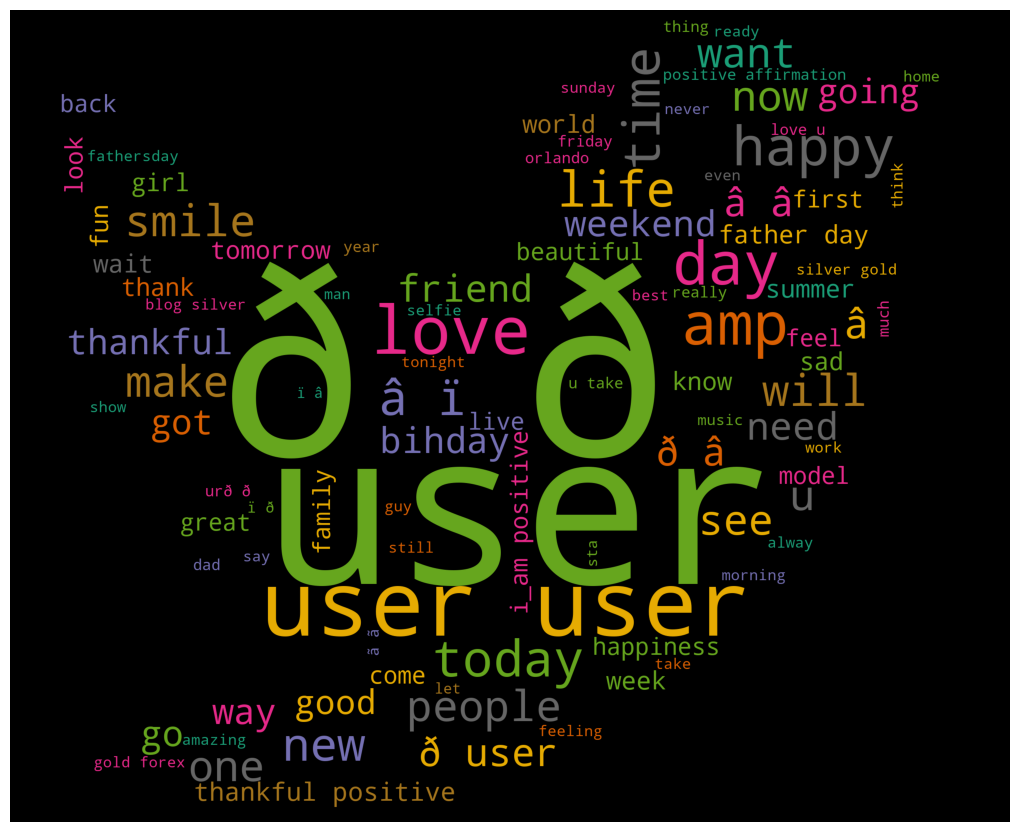

In [14]:
negative_data=train_data[train_data.label==0]
negative_tweet_text=" ".join(negative_data["tweet"].tolist())
plt.figure(figsize=(10,10))
wordcloud=WordCloud(stopwords=stopword,width=1600,height=800,max_words=100,mask=wordcloud_mask,colormap='Dark2').generate(negative_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

Häufigste Wörter: "user," "day," "happy," "love," "life."
Positiver Ton: Begriffe wie "happy," "love," "thankful," "smile" zeigen positive Themen.
Alltagsthemen: Wörter wie "family," "weekend," "today," "friend" deuten auf alltägliche und persönliche Inhalte hin.

### Most Frequent Words In Train Data

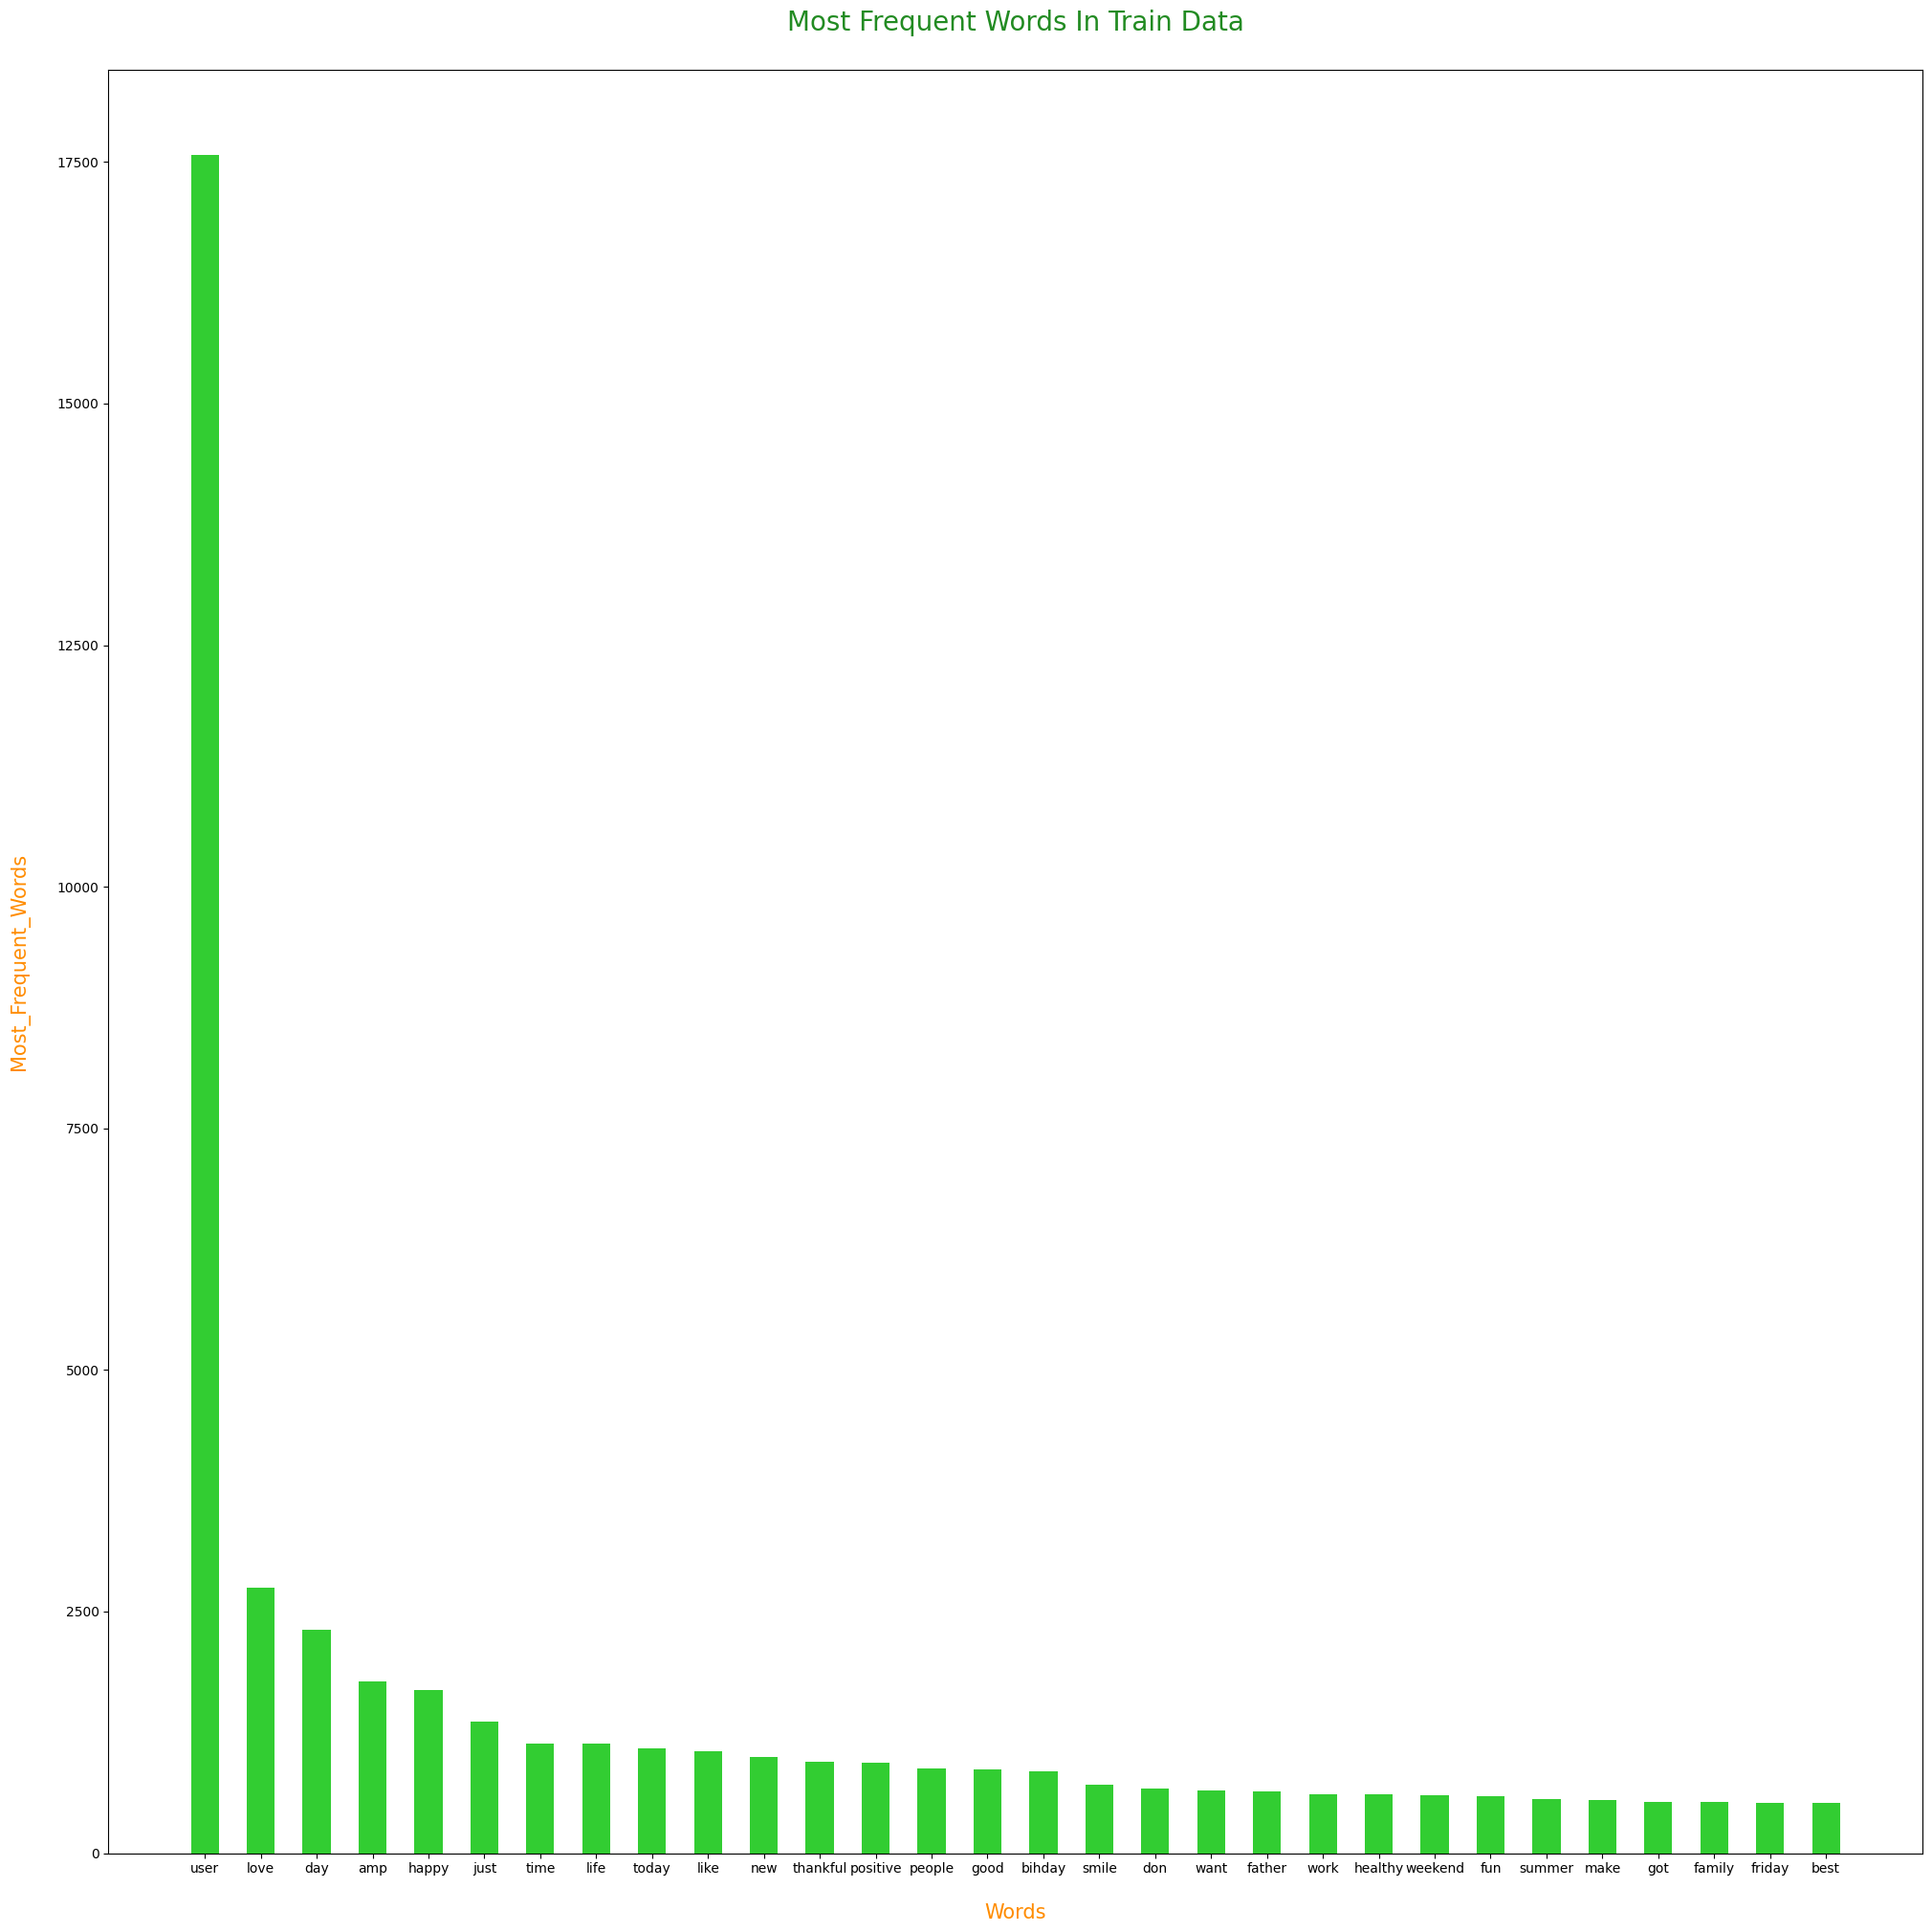

In [15]:
plt.figure(figsize=(20,20))
count_vectorizer=CountVectorizer(stop_words="english")
word=count_vectorizer.fit_transform(train_data.tweet)
sum_words=word.sum(axis=0)
most_freq_words=[(all_word,sum_words[0,i]) for all_word,i in count_vectorizer.vocabulary_.items()]
most_freq_words=sorted(most_freq_words,key=lambda x:x[1],reverse=True)

frequent_words=pd.DataFrame(most_freq_words,columns=["Words","Most_Frequent_Words"])

word_list = list(frequent_words.head(30).Words)
word_value_list = list(frequent_words.head(30).Most_Frequent_Words)

plt.bar(word_list, word_value_list, color ="limegreen",width=0.5)
plt.xlabel("\nWords",fontsize=15,color="darkorange")
plt.ylabel("Most_Frequent_Words\n",fontsize=15,color="darkorange")
plt.title("Most Frequent Words In Train Data\n",fontsize=20,color="forestgreen")
plt.tight_layout(pad=0)
plt.show()

## Data Preprocessing And Cleaning


import re
from nltk.corpus import stopwords

def clean_text(tweet):
    tweets = " ".join(filter(lambda x: x[0] != '@', tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if word not in set(stopwords.words('english'))]
    tweets = " ".join(tweets)
    return tweets

In [16]:
import re
from nltk.corpus import stopwords

def clean_text(tweet):
    tweets = " ".join(filter(lambda x: x[0] != '@', tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if word not in set(stopwords.words('english'))]
    tweets = " ".join(tweets)
    return tweets

In [17]:
train_data['clean_tweet_text'] = train_data.tweet.apply(clean_text)

In [18]:
train_data.head()

,tweet,label,clean_tweet_text
0,@user when a father is dysfunctional and is s...,0,father dysfunctional selfish drags kids dysfun...
1,@user @user thanks for #lyft credit i can't us...,0,thanks lyft credit use cause offer wheelchair ...
2,bihday your majesty,0,bihday majesty
3,#model i love u take with u all the time in ...,0,model love u take u time ur
4,factsguide: society now #motivation,0,factsguide society motivation


### Extracting Hashtag Words

In [19]:
import re

def extract_hashtag(tweet):
    tweets = " ".join(filter(lambda x: x[0] == '#', tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()  # Split into words
    tweets = " ".join(tweets)  # Rejoin words into a single string
    return tweets

In [20]:
train_data['word_with_hashtag'] = train_data.tweet.apply(extract_hashtag)


In [21]:
train_data.head()

,tweet,label,clean_tweet_text,word_with_hashtag
0,@user when a father is dysfunctional and is s...,0,father dysfunctional selfish drags kids dysfun...,run
1,@user @user thanks for #lyft credit i can't us...,0,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
2,bihday your majesty,0,bihday majesty,
3,#model i love u take with u all the time in ...,0,model love u take u time ur,model
4,factsguide: society now #motivation,0,factsguide society motivation,motivation


### Most Common Hate-speech Words With Hashtag


        words  frequency
0       trump        134
1    politics         95
2   allahsoil         92
3     libtard         76
4     liberal         75
5         sjw         74
6     retweet         63
7       miami         46
8       black         44
9        hate         32
10      tampa         32
11          s         28
12      bigot         28
13        blm         28
14   hispanic         28


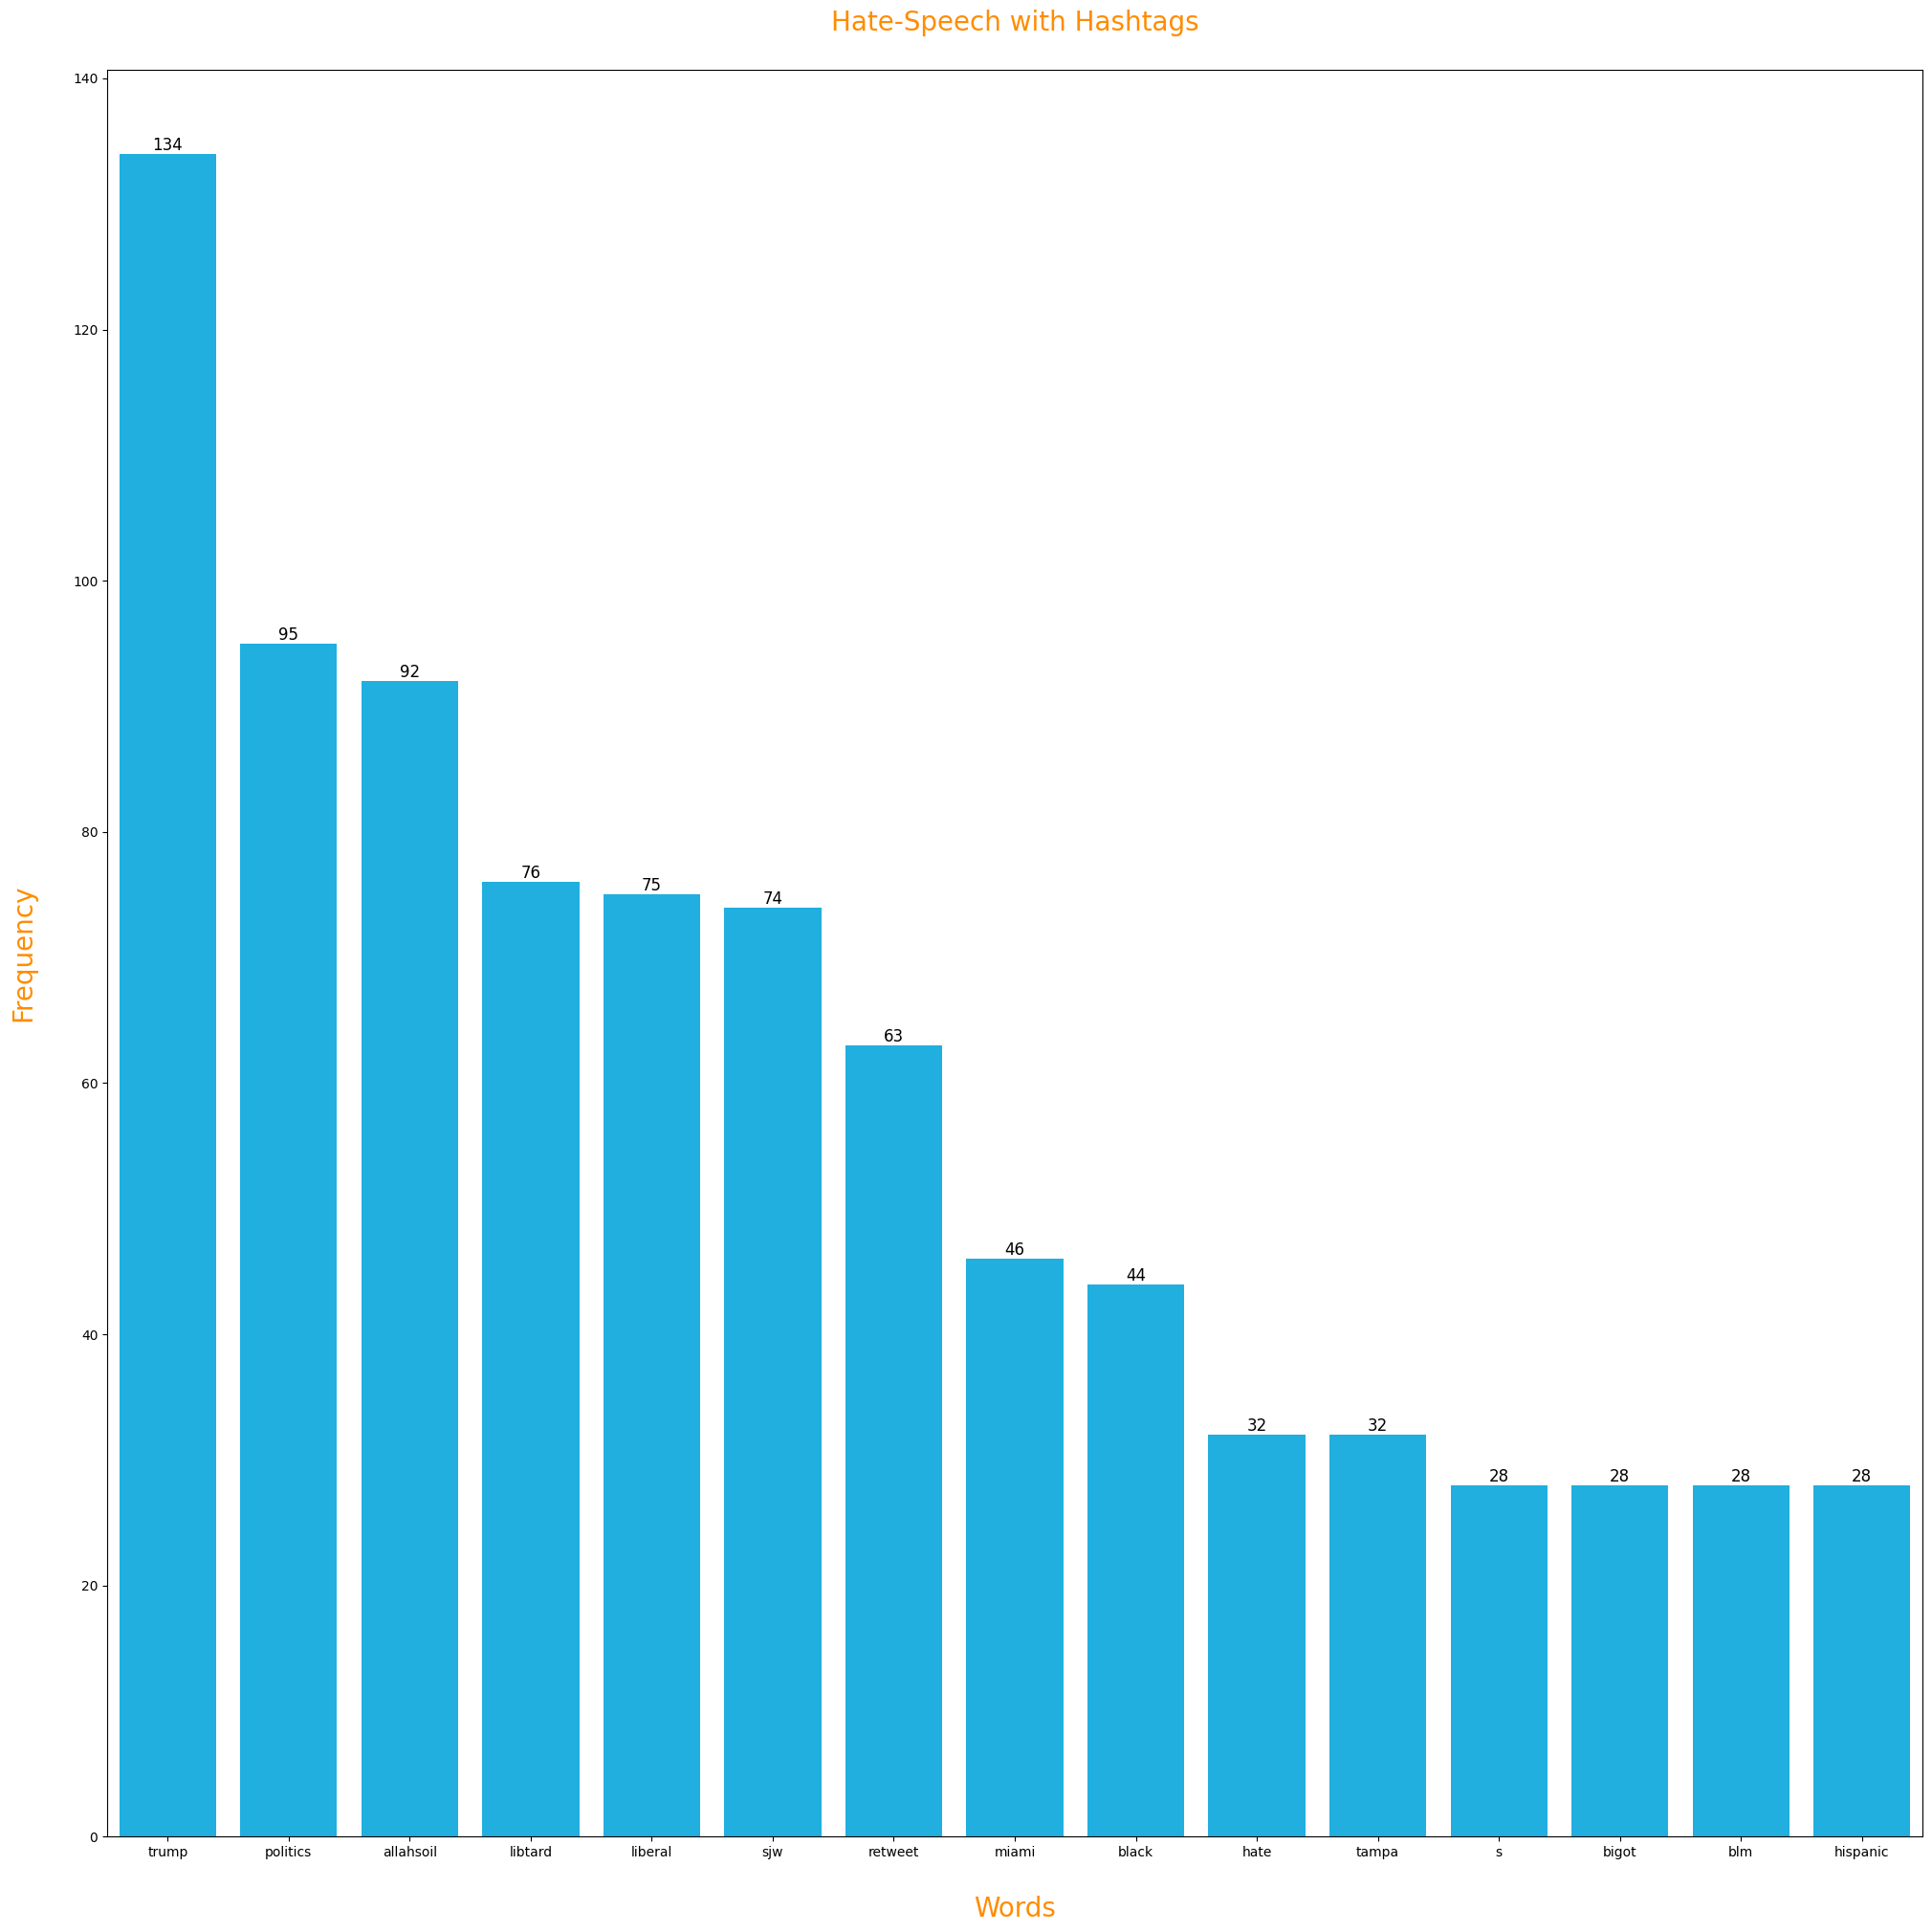

In [30]:
# positive_hashtag = FreqDist(list(" ".join(train_data[train_data['label'] == 1]['word_with_hashtag']).split())).most_common(15)
# positive_data = pd.DataFrame(positive_hashtag, columns=['words', 'frequency'])

# positive_data_top_20 = positive_data.nlargest(columns='frequency', n=20)

# print(positive_data_top_20)

# plt.figure(figsize=(20, 20))
# bar_plot = sns.barplot(x='words', y='frequency', data=positive_data_top_20, color="deepskyblue")

# for index, value in enumerate(positive_data_top_20['frequency']):
#     bar_plot.text(index, value, str(value), color='black', ha="center", va='bottom', fontsize=12)

# plt.title('Hate-Speech with Hashtags\n', fontsize=20, color="darkorange")
# plt.xlabel("\nWords", fontsize=20, color="darkorange")
# plt.ylabel("Frequency\n", fontsize=20, color="darkorange")
# plt.tight_layout(pad=0)
# plt.show()


### Most Common No Hate-Speech Words With Hashtag


          words  frequency
0          love       1580
1      positive        879
2         smile        577
3       healthy        575
4      thankful        471
5           fun        463
6          life        437
7        summer        392
8         model        365
9          cute        364
10  affirmation        363
11         blog        352
12   fathersday        340
13            i        338
14           me        336


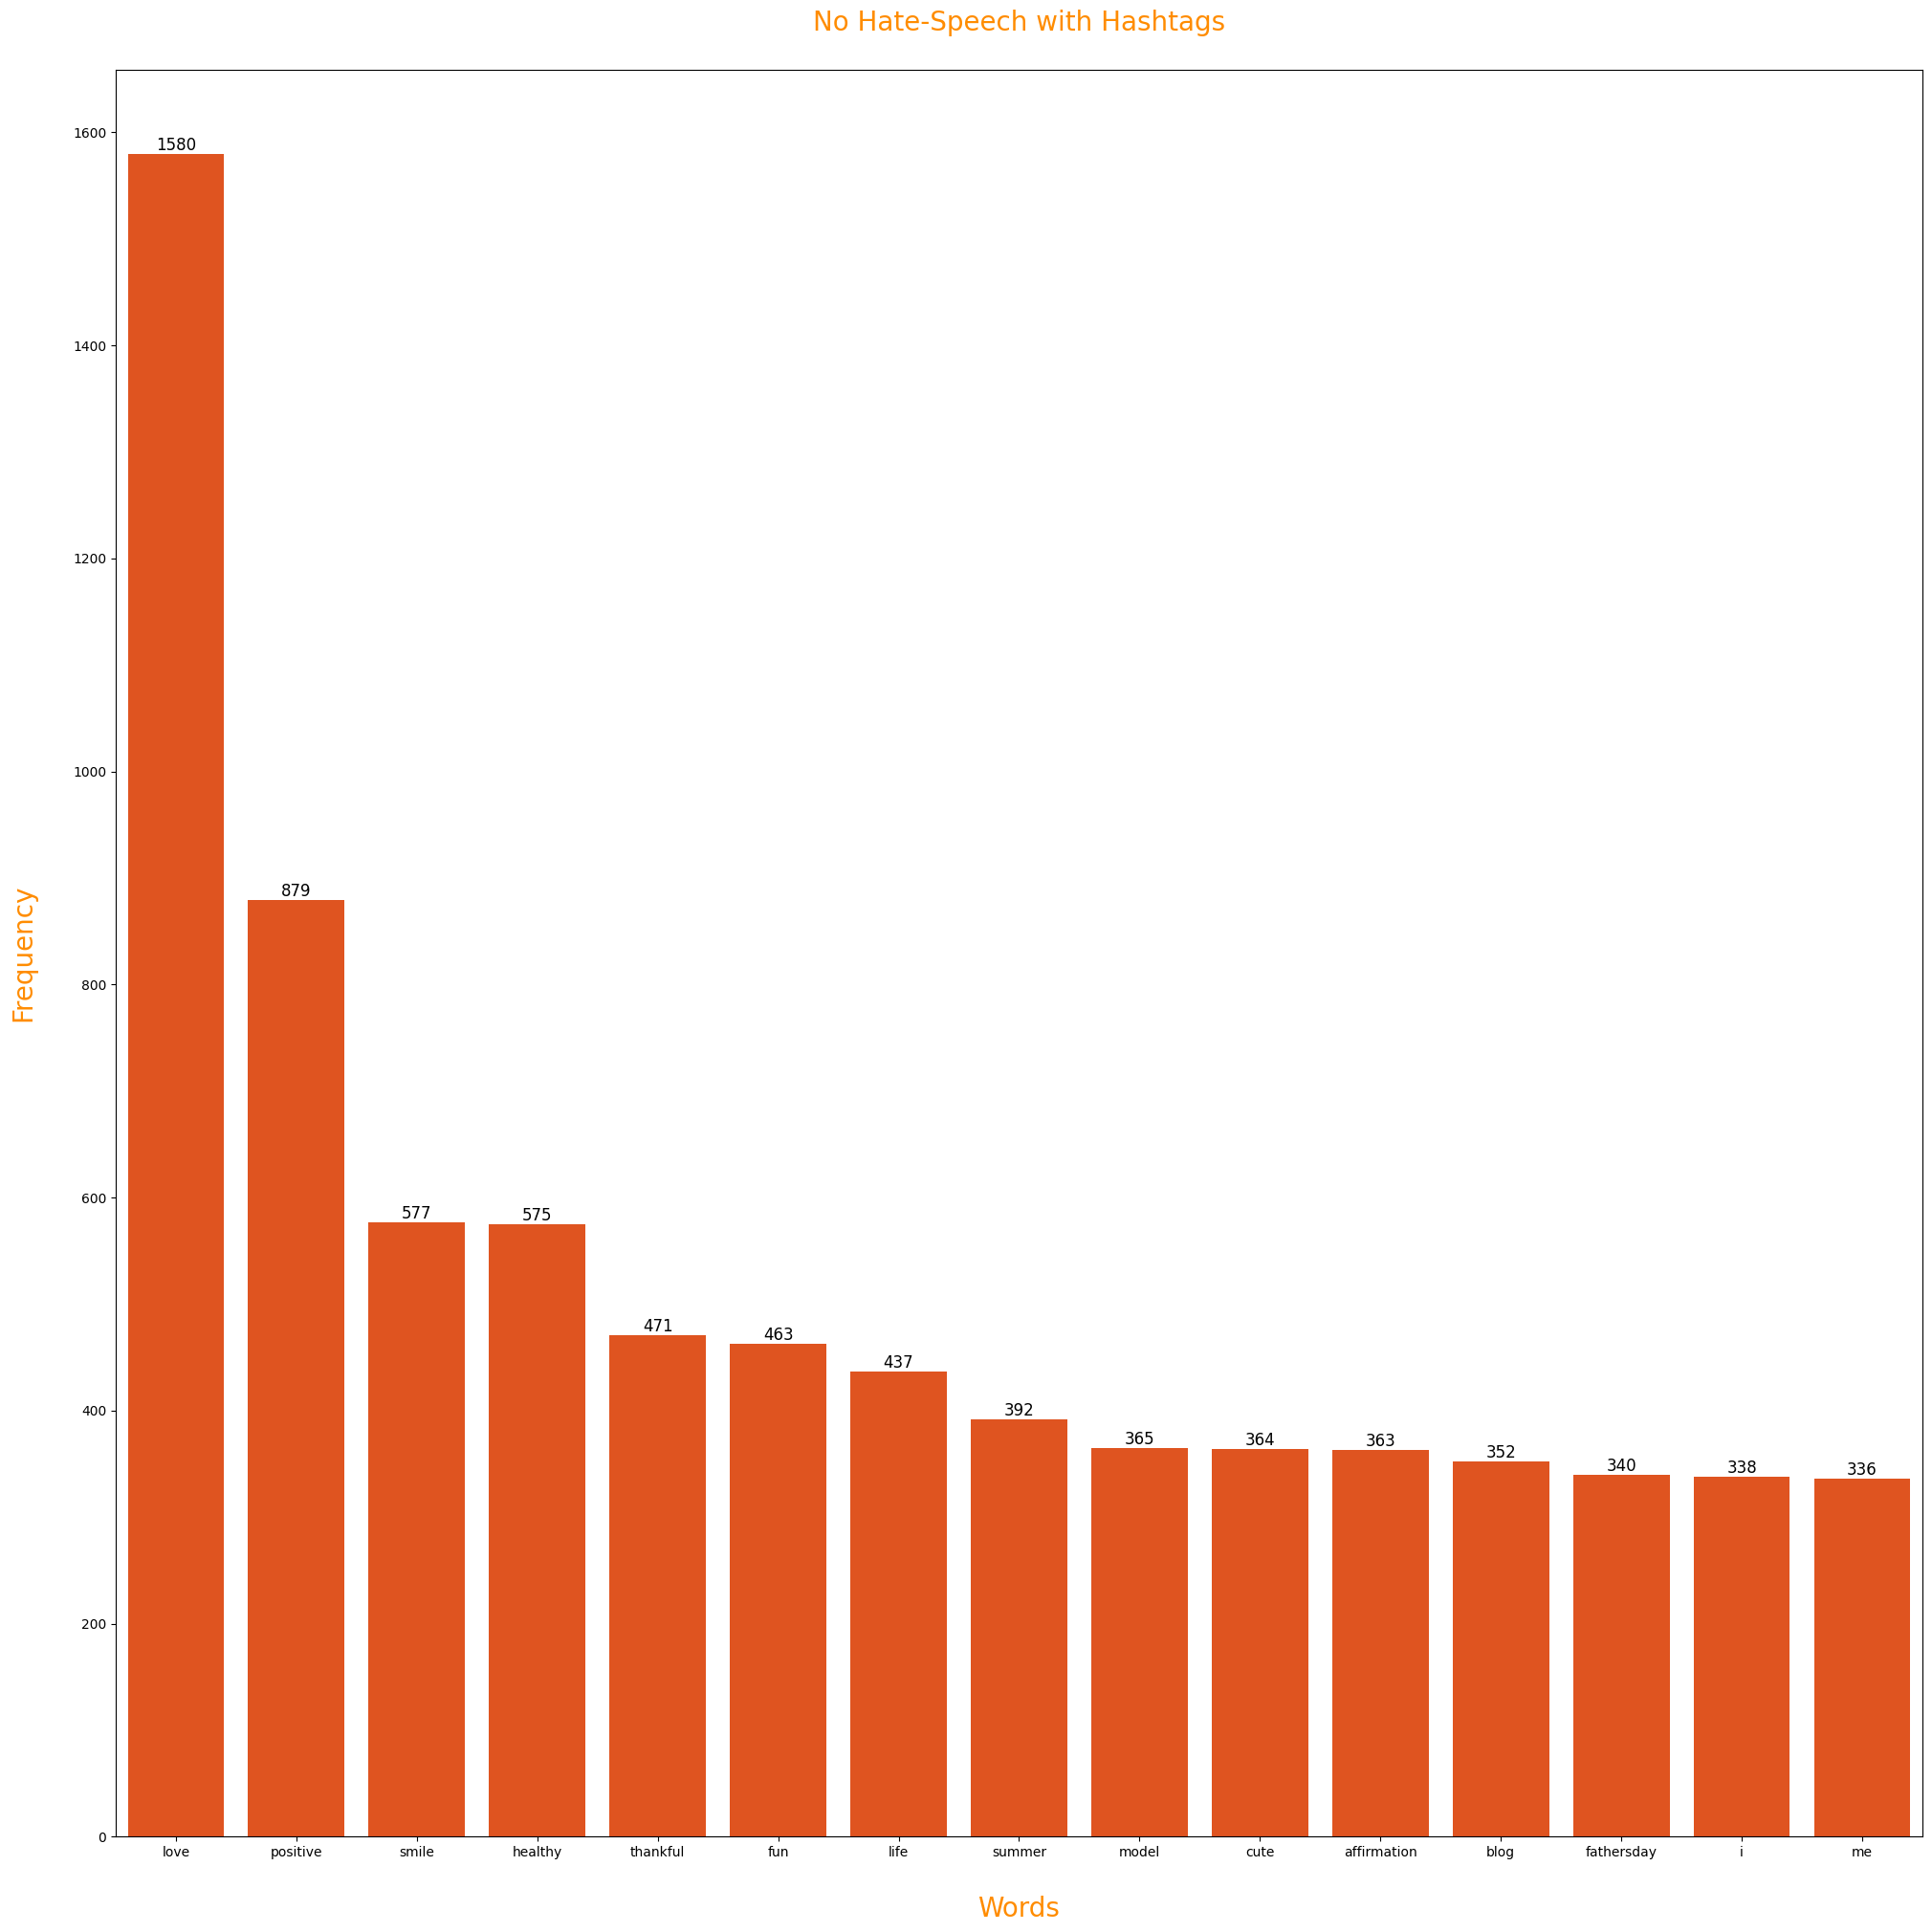

In [31]:
negative_hashtag = FreqDist(list(" ".join(train_data[train_data['label'] == 0]['word_with_hashtag']).split())).most_common(15)
negative_data = pd.DataFrame(negative_hashtag, columns=['words', 'frequency'])

negative_data_top_20 = negative_data.nlargest(columns='frequency', n=20)

print(negative_data_top_20)

plt.figure(figsize=(20, 20))
bar_plot = sns.barplot(x='words', y='frequency', data=negative_data_top_20, color="orangered")

for index, value in enumerate(negative_data_top_20['frequency']):
    bar_plot.text(index, value, str(value), color='black', ha="center", va='bottom', fontsize=12)

plt.title('No Hate-Speech with Hashtags\n', fontsize=20, color="darkorange")
plt.xlabel("\nWords", fontsize=20, color="darkorange")
plt.ylabel("Frequency\n", fontsize=20, color="darkorange")
plt.tight_layout(pad=0)
plt.show()


In [40]:
train_data['num_mentions'] = train_data['tweet'].apply(lambda x: x.count('@'))

train_data['num_hashtags'] = train_data['tweet'].apply(lambda x: x.count('#'))

train_data.head()


,tweet,label,clean_tweet_text,word_with_hashtag,num_mentions,num_hashtags
0,@user when a father is dysfunctional and is s...,0,father dysfunctional selfish drags kids dysfun...,run,1,1
1,@user @user thanks for #lyft credit i can't us...,0,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked,2,3
2,bihday your majesty,0,bihday majesty,,0,0
3,#model i love u take with u all the time in ...,0,model love u take u time ur,model,0,1
4,factsguide: society now #motivation,0,factsguide society motivation,motivation,0,1


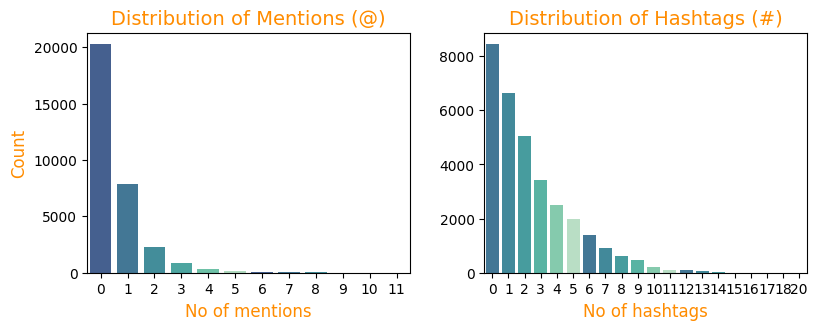

In [42]:
plt.figure(figsize=(9, 3))

# Erster Subplot: Verteilung der Mentions (@)
plt.subplot(1, 2, 1)
sns.countplot(x='num_mentions', data=train_data, palette=sns.color_palette("mako", n_colors=9)[3:])
plt.xlabel('No of mentions', fontsize=12, color='darkorange')
plt.ylabel('Count', fontsize=12, color='darkorange')
plt.title('Distribution of Mentions (@)', fontsize=14, color='darkorange')

# Zweiter Subplot: Verteilung der Hashtags (#)
plt.subplot(1, 2, 2)
sns.countplot(x='num_hashtags', data=train_data, palette=sns.color_palette("mako", n_colors=11)[5:])
plt.xlabel('No of hashtags', fontsize=12, color='darkorange')
plt.ylabel('')
plt.title('Distribution of Hashtags (#)', fontsize=14, color='darkorange')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.23, hspace=0.3)

plt.show()

<Figure size 600x300 with 0 Axes>

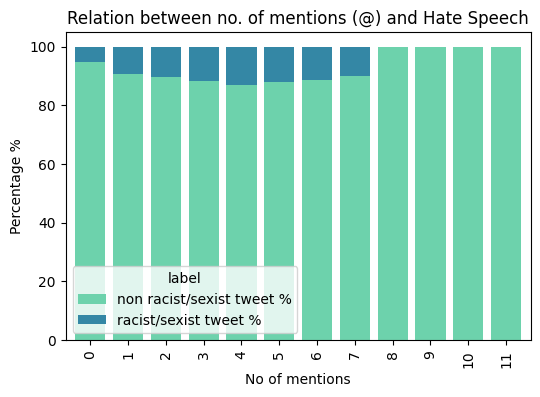

In [43]:
plt.figure(figsize=(6, 3))

# Erstellen der Kreuztabelle für die Anzahl der Mentions und das Label (0 = kein Hate Speech, 1 = Hate Speech)
mention_label_cross = pd.crosstab(train_data['num_mentions'], train_data['label'])

# Berechnung der Summe aller Tweets je nach Anzahl der Mentions
mention_label_cross['sum'] = mention_label_cross[0] + mention_label_cross[1]

# Berechnung des Prozentsatzes für nicht rassistische/sexistische Tweets
mention_label_cross['non racist/sexist tweet %'] = (mention_label_cross[0] / mention_label_cross['sum']) * 100

# Berechnung des Prozentsatzes für rassistische/sexistische Tweets
mention_label_cross['racist/sexist tweet %'] = (mention_label_cross[1] / mention_label_cross['sum']) * 100

# Entfernen der Spalten für absolute Werte (wir wollen nur die Prozentsätze anzeigen)
mention_label_cross = mention_label_cross.drop([0, 1, 'sum'], axis=1)

# Gestapeltes Balkendiagramm
mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel('No of mentions')
plt.ylabel('Percentage %')
plt.title('Relation between no. of mentions (@) and Hate Speech')
plt.show()


Sentiment     negative  positive
Actual Label                    
0                 5400     24320
1                 1030      1212


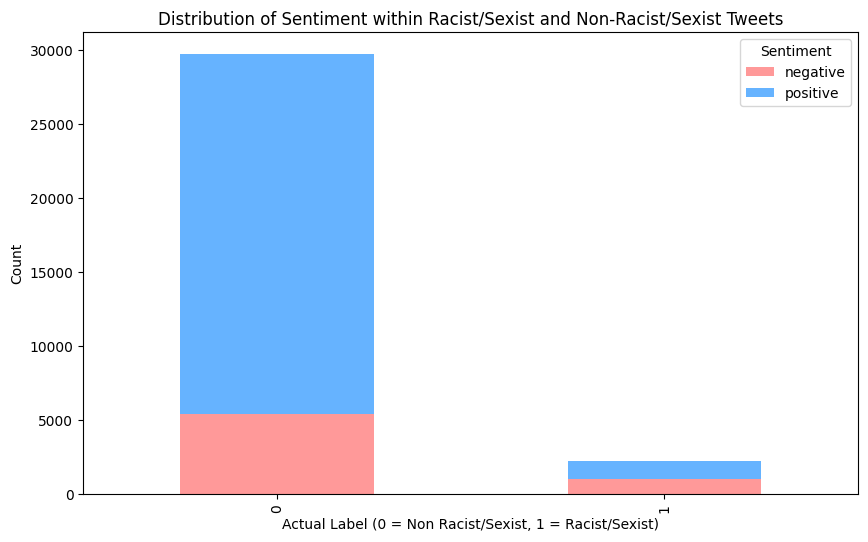

In [53]:
# Crosstab zur Analyse der Verteilung von Sentiment in den beiden Klassen (rassistisch/sexistisch oder nicht)
sentiment_vs_label = pd.crosstab(train_data['label'], train_data['Sentiment_Label'], rownames=['Actual Label'], colnames=['Sentiment'])

# Anzeige der Tabelle
print(sentiment_vs_label)

# Optional: Visualisierung der Verteilung
sentiment_vs_label.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ff9999', '#66b3ff'])
plt.title('Distribution of Sentiment within Racist/Sexist and Non-Racist/Sexist Tweets')
plt.xlabel('Actual Label (0 = Non Racist/Sexist, 1 = Racist/Sexist)')
plt.ylabel('Count')
plt.show()
